In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Adapted from https://github.com/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb

# Example of Efficient Track Anything for multiple objects tracking

`build_efficienttam_video_predictor` for video segmentation and tracking. 

First install `efficient_track_anything` environment.

You can also launch a local demo `python app.py` for track anything


<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Device: cuda
Image encoder compilation is enabled. First forward pass will be slow.


frame loading (JPEG): 100%|██████████| 200/200 [00:03<00:00, 59.83it/s]
/home/ybw/EfficientTAM/efficient_track_anything/efficienttam_video_predictor.py:795: UserWarning: cannot import name '_C' from 'efficient_track_anything' (/home/ybw/EfficientTAM/efficient_track_anything/__init__.py)

Skipping the post-processing step due to the error above. You can still use Efficient Track Anything and it's OK to ignore the error above.
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]/home/ybw/EfficientTAM/efficient_track_anything/efficienttam_video_predictor.py:795: UserWarning: cannot import name '_C' from 'efficient_track_anything' (/home/ybw/EfficientTAM/efficient_track_anything/__init__.py)

Skipping the post-processing step due to the error above. You can still use Efficient Track Anything and it's OK to ignore the error above.
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 200/200 [00:13<00:00, 15.0

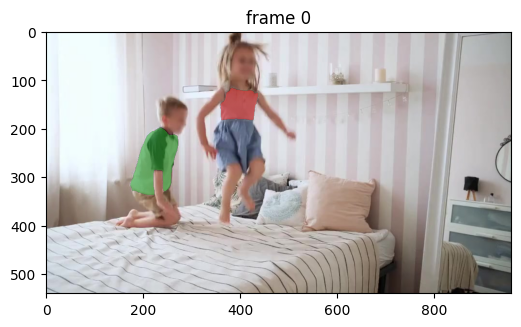

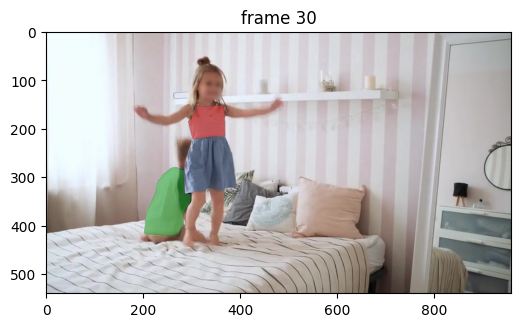

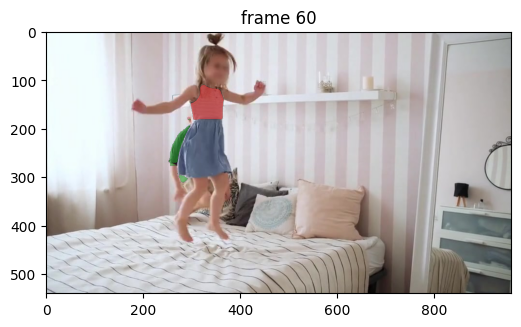

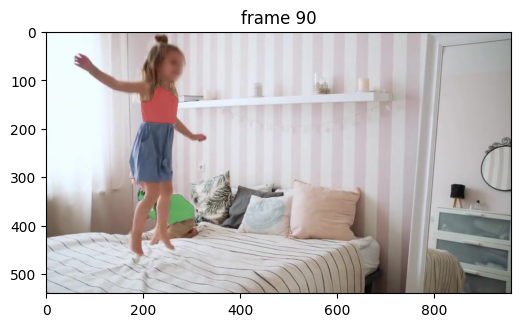

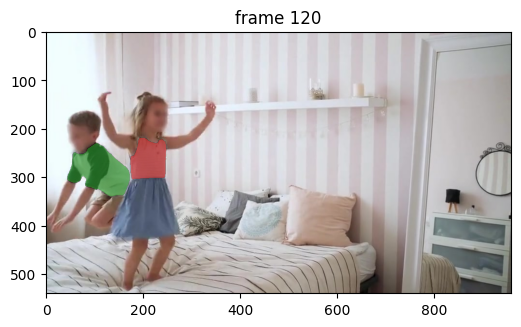

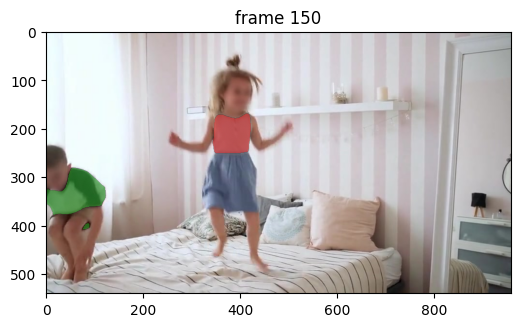

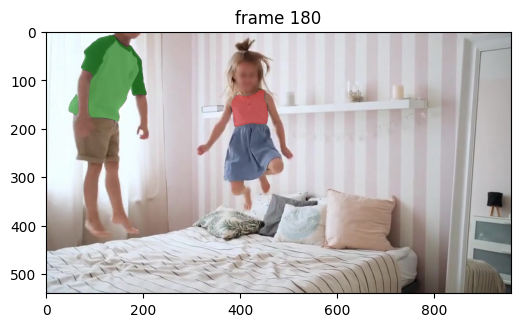

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

from efficient_track_anything.build_efficienttam import (
    build_efficienttam_video_predictor,
)
from PIL import Image

np.random.seed(5)
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p
    for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

# model
checkpoint = "../checkpoints/efficienttam_s.pt"
model_cfg = "configs/efficienttam/efficienttam_s.yaml"

predictor = build_efficienttam_video_predictor(model_cfg, checkpoint, device=device)


def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


inference_state = predictor.init_state(video_path=video_dir)
prompts = {}  # hold all the clicks we add for visualization

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    2  # give a unique id to each object we interact with (it can be any integers)
)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[200, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    2  # give a unique id to each object we interact with (it can be any integers)
)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[200, 300], [275, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)


ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    3  # give a unique id to each object we interact with (it can be any integers)
)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[400, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig = plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    fig.savefig("output_bedroom_frame_{}.png".format(out_frame_idx))